Continuation of work after data cleaning, feature enginnering and modeling of loan status. 

Disclaimer: This notebook and the work is done from a late Monday evening to early Tuesday morning before sunrise, with multiple cloud instances running to be able to show results. So there might be inconsistencies, typos. But I tried to recreate my workflow and the state of my mind closely, even including a interesting side note about not being able to use LightGBM GPU docker and submitting a pull request 

# Grade Modeling

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns

In [0]:
df = pd.read_pickle('0930SundayUntitled')

In [0]:
df['last_pymnt_d'] = df['last_pymnt_d'].dt.strftime('%Y-%m')
df['issue_d'] =df['issue_d'].dt.strftime('%Y-%m')
df['last_credit_pull_d']=df['last_credit_pull_d'].dt.strftime('%Y-%m')
df['earliest_cr_line']=df['earliest_cr_line'].dt.strftime('%Y-%m')

In [0]:
df.info()

** Let us convert the grades and subgrades into numerical categories **

In [0]:
factor_grade = pd.factorize(df['grade'])
factor_grade

In [0]:
df['grade'] = factor_grade[0]

In [0]:
factor_subgrade = pd.factorize(df['sub_grade'])
factor_subgrade

In [0]:
df['sub_grade'] = factor_subgrade[0]

In [0]:
df.select_dtypes(exclude=[np.number]).head()

We see that the term of the loan is still in string/object format, let us convert that into int

In [0]:
df['term'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['term']=df['term'].astype(int)

Check if 'term' is properly converted

In [0]:
df['term'].head()

We remember that we converted emp_length. Check if it is in int format, if not, convert it to int

In [0]:
df['emp_length'].head()

In [0]:
df['emp_length']= df['emp_length'].astype(int)

In [0]:
df.select_dtypes(object).columns

In [0]:
from sklearn import preprocessing
count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:     
            le = preprocessing.LabelEncoder()
            df[col] = le.fit_transform(df[col])
            count += 1
            print (col)
            
print('%d columns were label encoded.' % count)

In [0]:
df.select_dtypes(object).columns

For object columsn with more than 2 classes, we shall use one hot encoding instead. If we were to apply label encoding for multi class objects, we would potentailly make the system think that there is order between 0, 1, and 2, etc. as representation type. 

In [0]:
df = pd.get_dummies(df)
print(df.shape)

We now fill in the null values with zero in place

In [0]:
df.dropna(inplace=True)

In [0]:
df.to_pickle('Before_Modeling_Grades')

## Modeling

Note that loan status can be included in the features, and I do not consider it a data leakage program since in reality, we always have the loan status in hand. Our goal is to reproduce the grading system that Lending Club uses. 

### 1. Bagging

In [0]:
df.read_pickle('Before_Modeling_Grades')

In [0]:
df.drop('sub_grade', axis =1)

In [0]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import gc

In [0]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))    
        

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('grade',axis=1),df['grade'],test_size=0.15,random_state=101)

In [0]:
gc.collect()

8783

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test=sc.transform(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
clf_rf = RandomForestClassifier(n_estimators=10, random_state=21) # I changed it to 10 for faster training time
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=21, verbose=0, warm_start=False)

In [0]:
print_score(clf_rf, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.7605

Classification Report: 
               precision    recall  f1-score   support

           0       0.69      0.88      0.77     94286
           1       0.60      0.51      0.56     46374
           2       0.82      0.86      0.84     94793
           3       0.96      0.86      0.91     62402
           4       0.49      0.22      0.30     19194
           5       0.47      0.08      0.13      5807
           6       0.42      0.01      0.02      1668

   micro avg       0.76      0.76      0.76    324524
   macro avg       0.64      0.49      0.50    324524
weighted avg       0.75      0.76      0.74    324524


Confusion Matrix: 
 [[83121  3432  7304   257   164     8     0]
 [19081 23837  1443    60  1880    72     1]
 [10969   349 81431  2032    12     0     0]
 [  585    37  8009 53771     0     0     0]
 [ 5346  8971   426    10  4169   267     5]
 [ 1276  2194    66     2  1801   449    19]
 [  304   594    30     1   556   165    18]]



### 2. Boosting

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import gc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [0]:
df=pd.read_pickle('Before_Modeling_Grades')
df = df.drop('sub_grade', axis =1)

In [0]:
def kfold_lightgbm(train_df, num_folds, stratified = False):
    print("Starting LightGBM. Train shape: {}".format(train_df.shape))
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)

    oof_preds = np.zeros(train_df.shape[0])

    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['grade']]
    
    # Splitting the training set into folds for Cross Validation
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['grade'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['grade'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['grade'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=12,#previous number 4
            n_estimators=100, # Previous number 10000
            learning_rate=0.1,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1
            #device= 'gpu',gpu_platform_id= 0,gpu_device_id= 0
            )

        # Fitting the model and evaluating by AUC
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'logloss', verbose= 1000, early_stopping_rounds= 200)
        print_score(clf, train_x, train_y, valid_x, valid_y, train=False)
        # Dataframe holding the different features and their importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # Freeing up memory
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    display_importances(feature_importance_df)
    return feature_importance_df

In [0]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))  

In [0]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(15, 12))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

Starting LightGBM. Train shape: (2163488, 1317)
Training until validation scores don't improve for 200 rounds.
[1000]	training's multi_logloss: 0.0028125	training's multi_logloss: 0.0028125	valid_1's multi_logloss: 0.00508117	valid_1's multi_logloss: 0.00508117
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.0028125	training's multi_logloss: 0.0028125	valid_1's multi_logloss: 0.00508117	valid_1's multi_logloss: 0.00508117
Test Result:

accuracy score: 0.9986

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    209325
           1       1.00      1.00      1.00    103212
           2       1.00      1.00      1.00    211657
           3       1.00      1.00      1.00    137587
           4       0.99      1.00      1.00     42575
           5       0.99      0.99      0.99     13062
           6       0.98      0.96      0.97      3745

   micro avg       1.00      1.00      1.0

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


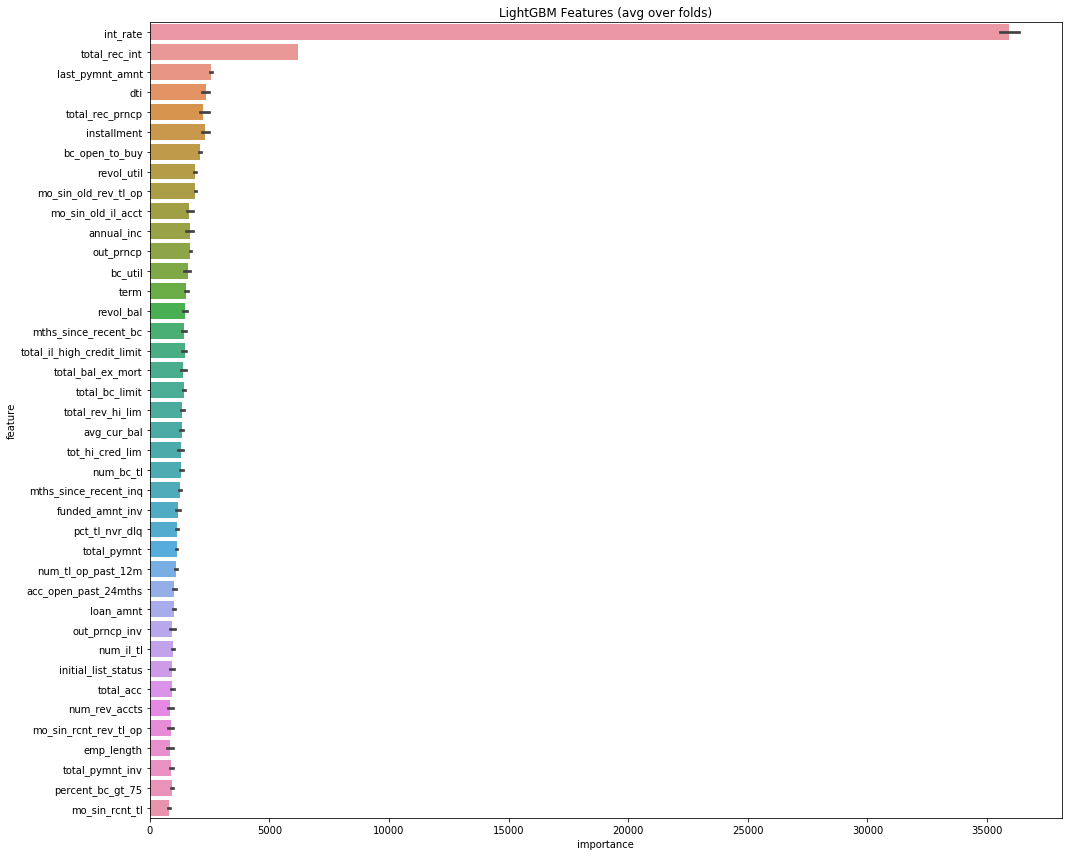

In [0]:
feat_importance = kfold_lightgbm(df, num_folds= 3, stratified= False)













We use **htop** in command line to monitor the cpu usage. To our delight, LightGBM is able to multi thread since we set the number of threads to be 12, and our **12-core** CPU were all used at full during training. However, the wait time is still very, very long

![alt text](https://storage.googleapis.com/lendingclubkaggle/LightGBMcpu.jpg)

In the mean time for training, this is what I started doing

1. Grabed some water, preferably sparkling water
2. Started another jupyter notebook for subgrade modeling, with the knowledge that not all Google Cloud 12 Cores are being used. Run the bagging for subgrades. 
3. While waiting for (2). Started another instance trying to do lightGBM on a gpu. This is based on a docker file of lightGBM on gpu https://github.com/microsoft/LightGBM/tree/master/docker/gpu. Starting an PyTorch from NVIDIA Google Cloud instance with nv-docker from Google CloudThis is a new instance based on the docker file of LightGBM on GPU provided in the official github. 

 Side note: I encountered many problem installing the docker file, mostly a conda yes/no question, and I figured out a better way to do that. I ended up submitting a **[pull request](https://github.com/microsoft/LightGBM/pull/2279
)** to the LightGBM hosted by Microsoft. But even after the pull request, the docker is not set up properly as the preinstalled pandas version is too old to even read our pickle file. We spent 1-hour installing a new, clean environment with useable pandas, which also made the LightBGM-on-GPU not callable. We did not pursue further

### Fast.AI  neural nets


In [0]:
!wget https://storage.googleapis.com/lendingclubkaggle/0930SundayUntitled

--2019-07-23 10:25:53--  https://storage.googleapis.com/lendingclubkaggle/0930SundayUntitled
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1402154085 (1.3G) [application/octet-stream]
Saving to: ‘0930SundayUntitled.2’

0930SundayUntitled. 100%[===================>]   1.31G   217MB/s    in 5.7s    

2019-07-23 10:25:59 (235 MB/s) - ‘0930SundayUntitled.2’ saved [1402154085/1402154085]



In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
from fastai.tabular import *

In [0]:
df = pd.read_pickle('0930SundayUntitled')

Converting the datetime objects into regular objects

In [0]:
df['last_pymnt_d'] = df['last_pymnt_d'].dt.strftime('%Y-%m')
df['issue_d'] =df['issue_d'].dt.strftime('%Y-%m')
df['last_credit_pull_d']=df['last_credit_pull_d'].dt.strftime('%Y-%m')
df['earliest_cr_line']=df['earliest_cr_line'].dt.strftime('%Y-%m')

Dealing with converting grade and subgrade into categories 


In [0]:
factor_grade = pd.factorize(df['grade'])
df['grade'] = factor_grade[0]
factor_subgrade = pd.factorize(df['sub_grade'])
df['sub_grade'] = factor_subgrade[0]

Dealing with term column

In [0]:
df['term'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['term']=df['term'].astype(int)

Dealing with Employment Length

In [0]:
df['emp_length']= df['emp_length'].astype(int)


In [0]:
#df.to_csv('BeforeFastai.csv')

In [0]:
#df = pd.read_csv('BeforeFastai.csv')

In [0]:
dep_var = 'grade'
df = df.drop('sub_grade',axis=1)

In [0]:
cat_names = df.select_dtypes(include=object).columns

In [0]:
procs = [FillMissing, Categorify, Normalize]



In [0]:
size=len(df)*0.2

In [0]:
test_index = np.random.choice(df.index, size=int(len(df)*0.2), replace=False)

In [0]:
cont_list, cat_list = cont_cat_split(df=df, max_card=25, dep_var='grade')


In [0]:
cat_list

['term',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'policy_code',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag',
 'TARGET']

In [0]:
data = TabularDataBunch.from_df('BeforeFastai.csv', df, dep_var=dep_var, valid_idx=test_index, procs=procs, cat_names=cat_list)

In [0]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)


In [0]:
learn.fit_one_cycle(1, 1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,0.234671,0.180922,0.979110,12:35


Notice that we achieved 0.979 accuracy with just one cycle trainig at 1e-2 learning rate. 

Training time takes **12:35 minutes** . This is a about 5 times faster than the most accurate model we tried, boosting with LightGBM, with bearable amount of performance compromise that should be able to minimized by further hyperparameter tuning. 

# Subgrade Modeling

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier
import numpy as np
import gc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [0]:
!wget https://storage.googleapis.com/lendingclubkaggle/Before_Modeling_Grades

--2019-07-23 09:37:16--  https://storage.googleapis.com/lendingclubkaggle/Before_Modeling_Grades
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4019800992 (3.7G) [application/octet-stream]
Saving to: ‘Before_Modeling_Grades’

Before_Modeling_Gra 100%[===================>]   3.74G   304MB/s    in 15s     

2019-07-23 09:37:31 (264 MB/s) - ‘Before_Modeling_Grades’ saved [4019800992/4019800992]



In [0]:
df = pd.read_pickle('Before_Modeling_Grades')

In [0]:
df = df.drop('grade', axis =1)

### 1. Bagging

In [0]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))    

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('sub_grade',axis=1),df['sub_grade'],test_size=0.15,random_state=101)
gc.collect()

57

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test=sc.transform(X_test)

/home/alexanderli/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/alexanderli/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/alexanderli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
clf_rf = RandomForestClassifier(n_estimators=10, random_state=21)
clf_rf.fit(X_train, y_train)
print_score(clf_rf, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.2473

Classification Report: 
               precision    recall  f1-score   support

           0       0.21      0.41      0.28     21033
           1       0.12      0.19      0.15     10328
           2       0.14      0.18      0.16     11777
           3       0.20      0.29      0.24     18524
           4       0.20      0.24      0.22     18653
           5       0.19      0.20      0.19     19187
           6       0.12      0.09      0.10      6906
           7       0.23      0.29      0.26     18524
           8       0.28      0.37      0.32     13608
           9       0.29      0.28      0.29     19849
          10       0.21      0.18      0.19     16889
          11       0.12      0.07      0.09      8162
          12       0.10      0.05      0.07      4684
          13       0.10      0.04      0.05      3242
          14       0.29      0.25      0.27     20010
          15       0.13      0.07      0.09      9201
          16      

We are not very happy with the **0.24** accuracy. Let us proceed to boosting with LightGBM for subgrade classification

### 2. Boosting

In [0]:
def kfold_lightgbm(train_df, num_folds, stratified = False):
    print("Starting LightGBM. Train shape: {}".format(train_df.shape))
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)

    oof_preds = np.zeros(train_df.shape[0])

    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['sub_grade']]
    
    # Splitting the training set into folds for Cross Validation
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['sub_grade'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['sub_grade'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['sub_grade'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=12,#previous number 4
            n_estimators=1000, # Previous number 10000
            learning_rate=0.02,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1
            #device_type=gpu,gpu_platform_id= 0,gpu_device_id= 0
            )

        # Fitting the model and evaluating by AUC
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'logloss', verbose= 1000, early_stopping_rounds= 200)
        print_score(clf, train_x, train_y, valid_x, valid_y, train=False)
        # Dataframe holding the different features and their importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # Freeing up memory
        del clf, train_x, train_y, valid_x, valid_y

    display_importances(feature_importance_df)
    return feature_importance_df

In [0]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))  

In [0]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(15, 12))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [0]:
feat_importance = kfold_lightgbm(df, num_folds= 3, stratified= False)

Starting LightGBM. Train shape: (2163488, 1317)
Training until validation scores don't improve for 200 rounds.
[1000]	training's multi_logloss: 0.0297969	training's multi_logloss: 0.0297969	valid_1's multi_logloss: 0.0331216	valid_1's multi_logloss: 0.0331216
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.0297969	training's multi_logloss: 0.0297969	valid_1's multi_logloss: 0.0331216	valid_1's multi_logloss: 0.0331216
Test Result:

accuracy score: 0.9939

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     46494
           1       1.00      1.00      1.00     23194
           2       0.99      1.00      1.00     26055
           3       1.00      0.99      1.00     41323
           4       1.00      1.00      1.00     41861
           5       1.00      1.00      1.00     41975
           6       0.99      0.99      0.99     15482
           7       0.99      1.00      1.00    

Even though we do not have enough time to finish the training (taking more than 3 hours, and still running), we can still see that we achieved some really impressive performance level at **0.9939**

## Fast.AI neural nets

Importing the data

In [0]:
!wget https://storage.googleapis.com/lendingclubkaggle/0930SundayUntitled

--2019-07-23 11:36:50--  https://storage.googleapis.com/lendingclubkaggle/0930SundayUntitled
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1402154085 (1.3G) [application/octet-stream]
Saving to: ‘0930SundayUntitled’

0930SundayUntitled  100%[===================>]   1.31G   205MB/s    in 6.7s    

2019-07-23 11:36:56 (199 MB/s) - ‘0930SundayUntitled’ saved [1402154085/1402154085]



In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
from fastai.tabular import *

In [0]:
df = pd.read_pickle('0930SundayUntitled')

Converting the datetime objects into regular objects

In [0]:
df['last_pymnt_d'] = df['last_pymnt_d'].dt.strftime('%Y-%m')
df['issue_d'] =df['issue_d'].dt.strftime('%Y-%m')
df['last_credit_pull_d']=df['last_credit_pull_d'].dt.strftime('%Y-%m')
df['earliest_cr_line']=df['earliest_cr_line'].dt.strftime('%Y-%m')

Dealing with converting grade and subgrade into categories 


In [0]:
factor_grade = pd.factorize(df['grade'])
df['grade'] = factor_grade[0]
factor_subgrade = pd.factorize(df['sub_grade'])
df['sub_grade'] = factor_subgrade[0]

Dealing with term column

In [0]:
df['term'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['term']=df['term'].astype(int)

Dealing with Employment Length

In [0]:
df['emp_length']= df['emp_length'].astype(int)


In [0]:
df.to_csv('BeforeFastai.csv')

In [0]:
df = pd.read_csv('BeforeFastai.csv')

In [0]:
dep_var = 'sub_grade'
df = df.drop('grade',axis=1)

In [0]:
cat_names = df.select_dtypes(include=object).columns

In [0]:
procs = [FillMissing, Categorify, Normalize]



In [0]:
size=len(df)*0.2

In [0]:
test_index = np.random.choice(df.index, size=int(len(df)*0.2), replace=False)

In [0]:
cont_list, cat_list = cont_cat_split(df=df, max_card=25, dep_var='sub_grade')


In [0]:
cat_list

['term',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'policy_code',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag',
 'TARGET']

In [0]:
data = TabularDataBunch.from_df('BeforeFastai.csv', df, dep_var=dep_var, valid_idx=test_index, procs=procs, cat_names=cat_list)

In [0]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)


In [0]:
learn.fit_one_cycle(1, 1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,1.162667,103.812439,0.877249,12:54


We are very happy with being able to achieve 0.877249 accuracy, with just 12:54 minutes of time in **fastai**. Compared to 0.9939 with **boosting** and 0.24 with **bagging**(random forrest), fast ai achieves accpetable amount of accuracy with less than one tenth training than than boosting. 

# Final Remark

In both cases of modeling grading and subgrading, we see that the fast.ai neural nets are the best model in terms of best balance between training time and performance. In production environment, we might still use LightGBM and boosting for the ultimate benchmark. But during traiing, it is both too long and distracting to use any training method that simply takes more than a cup-of-coffee time. 
![alt text](https://storage.googleapis.com/lendingclubkaggle/Screen%20Shot%202019-07-23%20at%206.04.12%20AM.png)
The above picture shows that our boosting training havn't stopped after 3 hours of using 12 high-powered cpu, with early stopping enabled and turned on in the LightGBM module

* why cup-of-coffee time is important? 

If it takes more than what is needed to consume a cup of coffee, our data scientists would most likely be distracted during training. He/She might be browsing Hackernews, going to social media, engage in small talks, and he/she will most likely forget what hyperparameters were used along the way. As a enginner, we really want the flow to stay productive.


All rights reserved. 
Alex Shengzhi Li
alex@alexli.me
